# Chapter09 Diffusion Model Implementation

- 서적내 8장에는 이론내용이 전부이기 때문에 9장에서 8장의 중요한 내용만 요약해 정리하였음.
- Diffusion Model과 원리에 대한 설명은 UNET뒤에 있음.

## Simple UNET

In [1]:
import torch
from torch import nn
from typing import override
from einops import rearrange

- 먼저 Convolution을 해주는 SubModule을 정의하자.

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
    
    @override
    def forward(self, x):
        return self.convs(x)

- random vector로 test 해본다.

In [3]:
test = ConvBlock(3, 64)
x = torch.randn(1, 3, 32, 32)
print(test(x).shape) 

torch.Size([1, 64, 32, 32])


- 그다음, ConvBlock을 하위 모듈로 가지는 Unet을 설계한다.

In [4]:
class UNet(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()

        self.down1 = ConvBlock(in_ch, 64)
        self.down2 = ConvBlock(64, 128)
        self.bot1 = ConvBlock(128, 256)
        self.up2 = ConvBlock(128 + 256, 128)
        self.up1 = ConvBlock(128 + 64, 64)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
    
    @override
    def forward(self, x):
        x1 = self.down1(x)              # (b, 64, H, W)
        x = self.maxpool(x1)            # (b, 64, H/2, W/2)
        x2 = self.down2(x)              # (b, 128, H/2, W/2)
        x = self.maxpool(x2)            # (b, 128, H/4, W/4)
        x = self.bot1(x)                # (b, 256, H/4, W/4)
        x = self.upsample(x)            # (b, 256, H/2, W/2)
        x = torch.cat([x, x2], dim=1)   # (b, 128 + 256, H/2, W/2)
        x = self.up2(x)                 # (b, 128, H/2, W/2)
        x = self.upsample(x)            # (b, 128, H, W)
        x = torch.cat([x, x1], dim=1)   # (b, 128 + 64, H, W)
        x = self.up1(x)                 # (b, 64, H, W)
        x = self.out(x)                 # (b, 1, H, W)
        return x

- 다시 random vector로 test를 진행해본다.

In [5]:
test = UNet().cuda()
x = torch.randn(1, 1, 28, 28).cuda()
print(test(x).shape)

torch.Size([1, 1, 28, 28])


#### Positional Encoding

In [6]:
import torch

def _pos_encoding(t, output_dim, device="cpu"):
    D = output_dim
    v = torch.zeros(D, device=device)
    i = torch.arange(0, D, device=device)
    div_term = 10000 ** (i / D)
    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[0::2])
    return v

def pos_encoding(ts, output_dim, device="cpu"):
    batch_size = len(ts)
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        v[i] = _pos_encoding(ts[i], output_dim, device)
    return v

- Positional Encoding에 관한 자세한 내용은 "Attention Is All You Need(2017)"를 참고하세요.

In [7]:
v = pos_encoding(torch.arange(100), 256)
print(v.shape)

torch.Size([100, 256])


#### PosEncoding - Visualization

<Figure size 640x480 with 0 Axes>

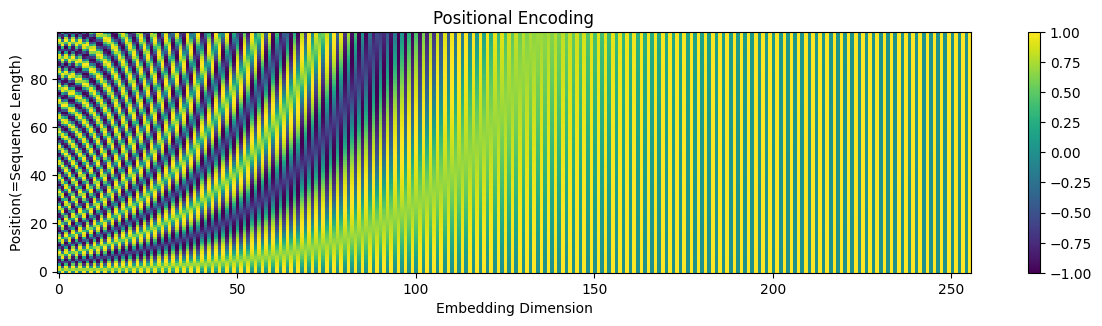

In [8]:
import numpy as np
import matplotlib.pyplot as plt

v = v.detach().cpu().numpy()
plt.clf()
plt.style.use("default")
fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow(v, aspect="auto", origin="lower", interpolation="none")
fig.canvas.draw()
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.title("Positional Encoding")
plt.xlabel("Embedding Dimension")
plt.ylabel("Position(=Sequence Length)")
plt.show()

## ConvBlock with Positional Encoding

- convolution block에 위치 인코딩 입력을 추가로 받을 수 있도록 개조한다.

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )
    
    @override
    def forward(self, x, v):
        v = self.mlp(v)
        v = rearrange(v, 'N C -> N C 1 1')
        y = self.convs(x + v)
        return y

- test를 해보자.

In [10]:
block = ConvBlock(3, 64, 256)
x = torch.randn(1, 3, 32, 32) # (b, c, h, w)
v = torch.randn(1, 256) # (b, time_embed_dim)
print(block(x, v).shape)

torch.Size([1, 64, 32, 32])


## UNET with Pos-Encoding

In [11]:
class UNet(nn.Module):
    def __init__(self, in_ch=1, time_embed_dim=100):
        super().__init__()

        self.time_embed_dim = time_embed_dim
        self.down1 = ConvBlock(in_ch, 64, time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim)
        self.up1 = ConvBlock(64 + 128, 64, time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, 1)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
    
    @override
    def forward(self, x, timesteps):
        v = pos_encoding(timesteps, self.time_embed_dim, x.device)

        x1 = self.down1(x, v)           # (b, 64, H, W)
        x = self.maxpool(x1)            # (b, 64, H/2, W/2)
        x2 = self.down2(x, v)           # (b, 128, H/2, W/2)
        x = self.maxpool(x2)            # (b, 128, H/4, W/4)

        x = self.bot1(x, v)             # (b, 256, H/4, W/4)

        x = self.upsample(x)            # (b, 256, H/2, W/2)
        x = torch.cat([x, x2], dim=1)   # (b, 256 + 128, H/2, W/2)
        x = self.up2(x, v)              # (b, 128, H/2, W/2)
        x = self.upsample(x)            # (b, 128, H, W)
        x = torch.cat([x, x1], dim=1)   # (b, 128 + 64, H, W)
        x = self.up1(x, v)              # (b, 64, H, W)
        x = self.out(x)                 # (b, 1, H, W)
        return x

- Diffusion model의 확산 과정을 구현한다.
- q(x_t | x_t-1) ... 즉 특정 한시점 이전의 이미지에 노이즈를 더하는 순방향 확산을 구현한다.

In [12]:
x = torch.randn(3, 64, 64).cuda()
T = 1000
betas = torch.linspace(0.0001, 0.02, T).cuda()

for t in range(T):
    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

In [13]:
import os
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

file_path = "./flower.png"
image = plt.imread(file_path)
print(image.shape)

preprocess = transforms.ToTensor()
x = preprocess(image)
print(x.shape)

(64, 64, 3)
torch.Size([3, 64, 64])


In [14]:
def reverse_to_image(x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    to_pil = transforms.ToPILImage()
    return to_pil(x)

### Forward Diffusion Process - q(x_t | x_t-1)

- `Forward Diffsuion`은 원데이터 `x_0`에 `random gaussian noise`를 t번 추가해 `x_t`를 얻어내는 과정이다. 반복문으로 이를 구현하면 마르코프 과정에 따라 `noise`를 `t`번 추가해야 한다. 
- 물론, 그렇게 하지 않고도 한번에 `x_t`로 이동할 수 있는 방법이 있긴하다.(추후 알아본다).

- $ x_{t-1} \Rightarrow x_t $ 로 갈 때의 과정의 공식은 다음과 같다.

- $$ q(x_t|x_{t-1}) = N(x_t;\sqrt{1-\beta_{t}}\,x_{t-1}, \beta_{t}I) $$

- beta는 noise scheduling방식에 따라 값이 달라지는데, 총 T개만큼의 value를 가지고 있다. 그리고 노이즈를 추가할 때 저러한 방법으로 노이즈를 추가하는 이유는 분산을 일정하게 유지해주기 위해서이다. 
- 좀더 정확하게 말하면 위공식으로 노이즈를 추가해주면, x_t와 x_t-1의 분산이 일정하게 유지가 된다. 공식을 유도해보면, 각각의 시점에 더해지는 노이즈의 독립성 때문에 공분산이 0이 되는 것을 이용하면 이 성질을 증명할 수 있다.(증명은 생략)
- $$ VAR[x_{t}] = VAR[x_{t-1}],\quad where\,\, x_t = \sqrt{1-\beta_{t}}x_{t-1} + \sqrt{\beta_{t}}\epsilon$$

- beta의 범위는 당연히 0에서 1사이여야 한다. 아니면 복소수가 되어버리기 때문에...


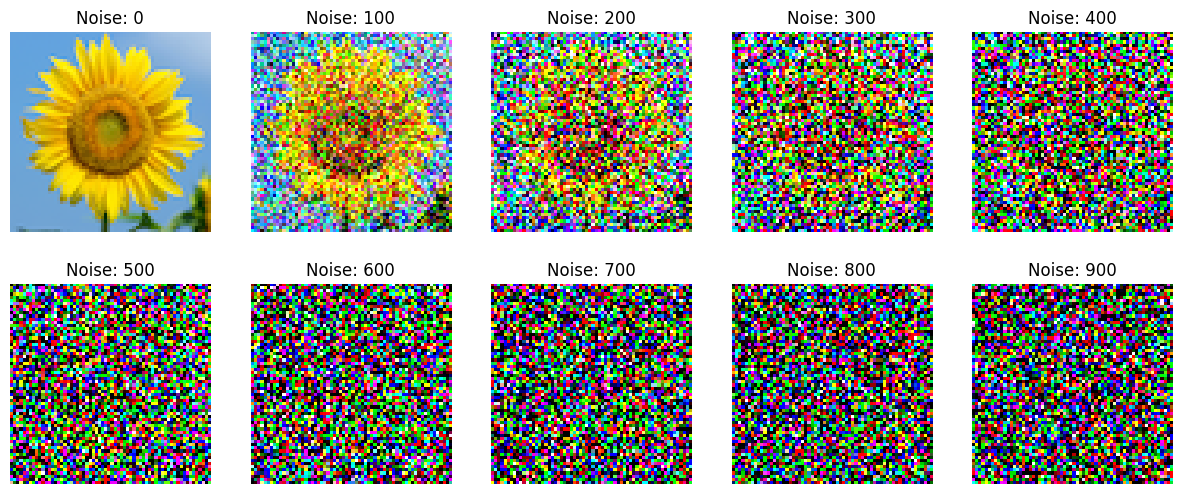

In [15]:
T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
imgs = []

for t in range(T):
    if t % 100 == 0:
        img = reverse_to_image(x)
        imgs.append(img)
    beta = betas[t]
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * eps

plt.figure(figsize=(15, 6))

for i, img in enumerate(imgs[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Noise: {i * 100}')
    plt.axis('off')
plt.show()

### Forward Diffusion Process - Sampling x_t from x_0 at once.

- 앞서 `t`번의 반복적인 노이즈 추가를 통해 원본 이미지가 완전한 `noise`로 가게되는 과정에 대해서 알아 보았다. 그런데, 여기서 저러한 중간 과정을 거치지 않고 한번에 특정 지점으로(e,g x_500) 이동할 수 있는 방법이 있다.
- $$ q(x_t|x_0) = N(x_t;\sqrt{\bar{\alpha_t}}x_0, (1-\bar{\alpha_{t}})I), \quad where\,\, \alpha_t=1-\beta_t,\,\, \bar{\alpha_t}=\alpha_{t}\alpha_{t-1}...\alpha_{1},  $$
- `1 - beta`를 계산한 뒤에 그에 대한 누적곱을 `alpha_bar`로 미리 저장한다. 그 후에 `beta`를 이용해서 노이즈를 추가하던 것 처럼 특정 `t-index`의 `alpha_bar`값을 이용해서 이미지에 노이즈를 더해주면 단번에 특정 `timestep`으로 이동할 수 있다.

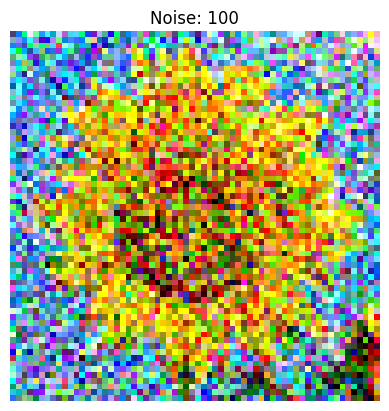

In [16]:
file_path = "./flower.png"
image = plt.imread(file_path)
x = preprocess(image)

T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)

def add_noise(x_0, t, betas):
    T = len(betas)
    assert t >= 1 and t <= T

    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim=0) # <- 누적곱을 이용해서 alpha_bar값을 미리 계산
    t_idx = t - 1
    alpha_bar = alpha_bars[t_idx]

    eps = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * eps # <- x_0에 노이즈를 추가해 x_t로 바로 이동

    return x_t

t = 100
x_t = add_noise(x, t, betas)

img = reverse_to_image(x_t)
plt.imshow(img)
plt.title(f'Noise: {t}')
plt.axis('off')
plt.show()

### Reverse Diffusion Process - Target Distribution
- 실제 Diffuser를 구현하기 전에 어떤 방식으로 이미지를 되돌리는지 알아보자.

- 방금 우리는 `x_0` -> `x_t`로 가는 forward diffusion process에 대해서 알아보았다. 이게 노이즈를 추가해주는 과정이기 때문에 간단하게 생각해보면, `x_t` -> `x_0`로 가는 reverse diffusion process로 노이즈를 제거해주는 과정이 있어야 원래 data로 돌아갈 수 있는 것이다.
- 그래서 `q(x_t-1|x_t, x_0)` 즉, 원본 데이터와 `t`시점의 data를 이용해 `t-1`시점의 데이터 분포를 구할 수 있고, 이것이 우리가 원하는 **reverse 과정에서의 목표 분포**이다.
- **이 분포의 수식 유도 과정은 매우 복잡하므로, 결론만 보도록 하자.**

    $$ q(x_{t-1}|x_t,x_0) = N(x_{t-1};\mu_{q}(x_t, x_0), \sigma_{q}^2(t)) $$

    $ where\,\, \mu_{q}(x_t, x_0) = \frac{\sqrt{\alpha_t}(1-\bar{\alpha_{t-1}})x_t + \sqrt{\bar{\alpha_{t-1}}}(1-\alpha_{t})x_0}{1-\alpha_{t}}, \,\, \sigma_q(t)^2 = \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_{t}} $  

- `alpha`와 `beta`는 `noise-scheduling`에 의존한다고 하였다.

    $ \alpha_t=1-\beta_t,\,\, \bar{\alpha_t}=\alpha_{t}\alpha_{t-1}...\alpha_{1} $


- 이 수식을 잘살펴보면 신경망이 무엇을 예측해야하는지 알 수있다. `sigma`는 `alpha`와 관련된 factor만 존재하므로 오로지 `noise-scheduling` 방법에만 의존한다. 그러나 `mu_q`의 경우에는 안쪽에 `x0`, 가 주어지므로 이것을 예측하거나 아니면 `mu`를 통째로 예측하거나 하는 일들을 신경망이 해야한다는 직관을 가질 수 있다. - (참고로 `x_t`는 입력으로 주어지므로 예측하는 것이 아니다.)

- 헷갈리면 안될 점은 여기서는 이것이 실제 데이터분포(q분포) 이기 때문에 원본 데이터인 `x_0`를 볼 수 있지만, 모델(=p_theta분포)은 볼 수 없기에 `x_0`를 예측하는 네트워크가 필요한 것이다. (또는 `x_0`를 예측하는 것 대신에 어떤 노이즈가 추가되었는지 예측하는 네트워크도 가능하다.)
- 다른말로, `q`의 아래 첨자가 없다는 것, 이것은 모델이 만들어내는 분포가 아니라는 뜻이다.

### Reverse Diffusion Process - Model Variation

- 이제 신경망이 하는 일에 대해서 자세히 알아보자. 추가된 noise를 예측하거나, 바로 원본 이미지를 예측하는 경우로 총 2가지가 있다.

    **1. x_0를 예측하는 신경망**

    - `x_t`를보고 그 시점에서 `x_0`를 바로 추정하는 신경망이다.

    $$ \mu_{q}(x_t, x_0) = \frac{\sqrt{\alpha_t}(1-\bar{\alpha_{t-1}})x_t + \sqrt{\bar{\alpha_{t-1}}}(1-\alpha_{t})\textcolor{red}{x_0}}{1-\alpha_{t}} $$

    - 그리고 이 수식을 신경망이 예측하는 요소로 바꾸면 다음과 같다.

    $$ \textcolor{red}{\hat{x_{\theta}}(x_t, t)} = NeuralNet(x_t, t;\,\theta) $$

    $$ \mu_{\theta}(x_t, t) = \frac{\sqrt{\alpha_t}(1-\bar{\alpha_{t-1}})x_t + \sqrt{\bar{\alpha_{t-1}}}(1-\alpha_{t})\textcolor{red}{\hat{x_{\theta}}(x_t, t)}}{1-\alpha_{t}} $$

    **2. noise를 예측하는 신경망**

    - `x_t`를보고 그 시점에서 추가된 `Gaussian-noise`인 `Epsilon`을 추정하는 신경망이다. 물론 `Gaussian-noise`앞에는 beta에 의존하는 상수가 곱해져서 scaling된다.
    - 앞서 forward-diffusion process에서 x_t를 sampling하는 공식을 대입해서 식을 수정하면 된다.
    
        $ \epsilon \sim N(0, I) $

        $ x_t = \sqrt{\bar{\alpha_{t}}}x_0 + \sqrt{1-\bar{\alpha_t}}\epsilon $

    - 이 식을 `x_0`에 대해서 정리한다.

        $ x_0 = \frac{x_t - \sqrt{1-\bar{\alpha_{t}}}\epsilon}{\sqrt{\bar{\alpha_{t}}}} $
    
    - 그다음 `x_0`를 저식에 대입하고 정리하면...

    $$ \mu_{q}(x_t, x_0) = \frac{\sqrt{\alpha_{t}}(1-\bar{\alpha_{t-1}})x_t + \sqrt{\bar{\alpha_{t-1}}}(1-\alpha_{t})\textcolor{red}{x_0}}{1-\alpha_{t}} = \frac{1}{\sqrt{\alpha_{t}}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}\textcolor{red}{\epsilon}) $$

    - 결국 예측해야하는 요소가 `x_0`에서 `epsilon`으로 바뀐 것이다. 

    $$ \textcolor{red}{\hat{\epsilon_{\theta}}(x_t, t)} = NeuralNet(x_t, t;\,\theta) $$

    $$ \mu_{\theta}(x_t, x_0) = \frac{1}{\sqrt{\alpha_{t}}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}\textcolor{red}{\epsilon_{\theta}(x_t, t)}) $$
    
    - Diffuser Class에서 구현된 denoise 메서드의 마지막 부분이 이 수식을 그대로 구현한 것이다.


### Diffusion Model - Loss function

- 각각의 Loss Function에 대해서 최종적으로 정리한다.
- 수식의 도출과정은 매우 복잡했지만, 마지막 Loss Function은 결국 MSE-Loss와 같은 간단한 형태로 귀결된다. 물론 전통적인 신경망과 비교해 `특정 timestep`에서 한시점 전으로 돌리는 것이 추가되었기 때문에 근사를 한번 더 해주어야 한다.
    - 1. 균등분포에서 시간 t를 sampling한다.
    - 2. t에서 x_t를 sampling한다.
    - 즉, 일반적인 신경망에서는 `전체 data` -> `batch`에서 나오는 gradient로 근사하지만, diffusion model에서는 `전체 data` -> `batch` -> `timestep`으로 한번더 안으로 들어가준다.
    - 그래서 여기서 도출되는 gradient가 정확하지 않기 때문에, `ODE/SDE Solver`를 학습시킬 때 더많은 컴퓨팅 자원과 시간을 필요로 하게 되는 것이다. 

    **1. x_0를 예측하는 신경망**

    - 이전 글에 따르면, 신경망이 예측하는 요소는 다음과 같았다.

        $ \textcolor{red}{\hat{x_{\theta}}(x_t, t)} = NeuralNet(x_t, t;\,\theta) $

        $ \mu_{\theta}(x_t, t) = \frac{\sqrt{\alpha_t}(1-\bar{\alpha_{t-1}})x_t + \sqrt{\bar{\alpha_{t-1}}}(1-\alpha_{t})\textcolor{red}{\hat{x_{\theta}}(x_t, t)}}{1-\alpha_{t}} $
    
    - Diffusion model에서도 VAE처럼 ELBO를 최소화 한다는 점은 같은데, 중간 과정은 생략하고 결과만 보도록 하자.

    $$ LOSS(x_0;\,\theta) = \frac{1}{\sigma_{q}^2(t)}||\mu_{\theta}(x_t, t)-\mu_{q}(x_t, x_0)||^2, \quad where\,\, \sigma_q(t)^2 = \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_{t}}$$

    - 그리고 이 식을 신경망이 예측하는 것을 기준으로 한번 더 정리해주면 다음과 같다.

    $$ LOSS(x_0;\,\theta) = \frac{1}{\sigma_{q}^2(t)}(\frac{\sqrt{\bar{\alpha}_{t-1}}(1-\alpha_{t})}{1-\bar{\alpha_{t}}})^2||\textcolor{red}{\hat{x_{\theta}}(x_t, t)}-x_{q}(x_t, x_0)||^2, \quad where\,\, \sigma_q(t)^2 = \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_{t}} $$

    **2. noise(=epsilon)을 예측하는 신경망**

    - 이것도 loss를 도출하는 과정은 1번과 거의 동일하다. 이 지점에서 부터 시작해보자.

        $ \textcolor{red}{\hat{\epsilon_{\theta}}(x_t, t)} = NeuralNet(x_t, t;\,\theta) $

        $ \mu_{\theta}(x_t, x_0) = \frac{1}{\sqrt{\alpha_{t}}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}\textcolor{red}{\epsilon_{\theta}(x_t, t)}) $
    
    - `mu`를 기준으로 할때의 loss-function은 다음과 같았다.

        $ LOSS(x_0;\,\theta) = \frac{1}{\sigma_{q}^2(t)}||\mu_{\theta}(x_t, t)-\mu_{q}(x_t, x_0)||^2, \quad where\,\, \sigma_q(t)^2 = \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_{t}} $

    - 그리고 위 식에 앞서 계산한 `mu_theta`와 `mu_q`식을 대입해 `epsilon`만 L2-Norm내에 남도록 식을 조정한다.

    $$ LOSS(x_0;\,\theta) = \frac{1}{\sigma_{q}^2(t)}\frac{(1-\alpha_{t})^2}{(1-\bar{\alpha_{t}})\alpha_{t}}||\textcolor{red}{\hat{\epsilon_{\theta}}(x_t, t)}-\epsilon||^2, \quad where\,\, \sigma_q(t)^2 = \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_{t}} $$

    - 또한 손실함수의 계수를 생략하면 마지막에 도출되는 손실함수는 다음과 같다.

        $ LOSS(x_0;\,\theta) = ||\textcolor{red}{\hat{\epsilon_{\theta}}(x_t, t)}-\epsilon||^2  $
    

### Diffuser 구현

- Diffuser는 신경망이 예측하는 것과 reverse/forward diffusion을 위해 해야하는 신경망 forward pass이외의 계산을 별도로 처리하는 것을 지원하는 모듈이다.
- 예를 들어 순방향 확산 과정에서 추가된 가우시안 노이즈를 예측하는 것은 신경망이 하지만, 그 가우시안 noise를 이용해 역확산 과정을 진행하는데 필요한 상수곱 등의 연산은 Diffuser Class가 맡아 처리한다.

In [17]:
from tqdm import tqdm

class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device="cpu"):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
    
    def add_noise(self, x_0, t): # <- forward diffusion process 에서 설명했던 method, x_t로 한번에 이동.
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()
        t_idx = t - 1

        alpha_bar = self.alpha_bars[t_idx]
        N = alpha_bar.size(0)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()

        t_idx = t - 1
        alpha = self.alphas[t_idx]
        alpha_bar = self.alpha_bars[t_idx]
        alpha_bar_prev = self.alpha_bars[t_idx - 1]

        N = alpha.size(0)
        alpha = alpha.view(N, 1, 1, 1)
        alpha_bar = alpha_bar.view(N, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(N, 1, 1, 1)

        model.eval()
        with torch.no_grad():
            eps = model(x, t) # model은 추가된 noise가 무엇인지 예측 (UNET here is it)
        model.train()

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0

        mu = (x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * eps) / torch.sqrt(alpha)
        std = torch.sqrt((1 - alpha) * (1 - alpha_bar_prev) / (1 - alpha_bar))
        return mu + std * noise # reverse process <- 한 스텝전의 이미지로 이동
    
    def reverse_to_image(self, x):
        x = x * 255
        x = x.clamp(0, 255)
        x = x.to(torch.uint8)
        x = x.cpu()
        to_pil = transforms.ToPILImage()
        return to_pil(x)
    
    def sample(self, model, x_shape=(20, 1, 28, 28)):
        batch_size = x_shape[0]
        x = torch.randn(x_shape, device=self.device)

        for i in tqdm(range(self.num_timesteps, 0, -1)):
            t = torch.tensor([i] * batch_size, device=self.device, dtype=torch.long)
            x = self.denoise(model, x, t) # 특정 timestep에서의 denoising을 반복적으로 호출
            """
            DDPM은 T번 동안 denoising 수행
            DDIM은 T보다는 작은 횟수로 denoising 수행(but deterministic, 여기는 구현 안되어 있음)
            """
        
        images = [self.reverse_to_image(x[i]) for i in range(batch_size)]
        return images


- `add_noise` method는 이전에서 설명한 바와 같이, 노이즈를 단번에 추가해주는 과정이다.
- `sample`과 `denoise`는 둘다 set인데, sample함수에서 denoise를 여러번(일반적으로 1000번이다.) 반복해서 호출하면서 노이즈를 원본이미지로 되돌리는 과정이다.

### Train Diffuser

In [23]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

img_size = 28
batch_size = 128
num_timesteps=1000
epochs=100
lr=1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"

def show_images(images, rows=2, cols=10):
    plt.clf()
    fig = plt.figure(figsize=(cols, rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i + 1)
            plt.imshow(images[i], cmap="gray")
            plt.axis("off")
            i += 1
    plt.show()

In [24]:
preprocess = transforms.ToTensor()
dataset = torchvision.datasets.MNIST(root="../data", train=True, transform=preprocess, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
diffuser = Diffuser(num_timesteps=num_timesteps, device=device)
model = UNet()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [25]:
losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for images, labels in tqdm(dataloader):
        optimizer.zero_grad()
        x = images.to(device)
        t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise_pred, noise)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1
    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f"Epoch: {epoch + 1}, Loss: {loss_avg}")


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 1, Loss: 0.04907951913853444


100%|██████████| 469/469 [00:28<00:00, 16.27it/s]


Epoch: 2, Loss: 0.02805427998018417


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 3, Loss: 0.024584684779108967


100%|██████████| 469/469 [00:28<00:00, 16.31it/s]


Epoch: 4, Loss: 0.022869272530873192


100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


Epoch: 5, Loss: 0.021725207861107803


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 6, Loss: 0.02083168492745807


100%|██████████| 469/469 [00:28<00:00, 16.25it/s]


Epoch: 7, Loss: 0.02012622220390069


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 8, Loss: 0.019444037310238967


100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


Epoch: 9, Loss: 0.018878259259198647


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 10, Loss: 0.018452442660212898


100%|██████████| 469/469 [00:28<00:00, 16.38it/s]


Epoch: 11, Loss: 0.018272437878064256


100%|██████████| 469/469 [00:28<00:00, 16.18it/s]


Epoch: 12, Loss: 0.020105592997820138


100%|██████████| 469/469 [00:28<00:00, 16.36it/s]


Epoch: 13, Loss: 0.01800731357846306


100%|██████████| 469/469 [00:28<00:00, 16.32it/s]


Epoch: 14, Loss: 0.01758181199685597


100%|██████████| 469/469 [00:28<00:00, 16.39it/s]


Epoch: 15, Loss: 0.017420088582392187


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 16, Loss: 0.01709531870350909


100%|██████████| 469/469 [00:28<00:00, 16.27it/s]


Epoch: 17, Loss: 0.017273572714391675


100%|██████████| 469/469 [00:28<00:00, 16.39it/s]


Epoch: 18, Loss: 0.016882749504721496


100%|██████████| 469/469 [00:28<00:00, 16.39it/s]


Epoch: 19, Loss: 0.01703952244127483


100%|██████████| 469/469 [00:28<00:00, 16.37it/s]


Epoch: 20, Loss: 0.01662045141765431


100%|██████████| 469/469 [00:28<00:00, 16.42it/s]


Epoch: 21, Loss: 0.016795899925519154


100%|██████████| 469/469 [00:28<00:00, 16.20it/s]


Epoch: 22, Loss: 0.016816647349993812


100%|██████████| 469/469 [00:28<00:00, 16.32it/s]


Epoch: 23, Loss: 0.016691384344562285


100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


Epoch: 24, Loss: 0.016466191107991027


100%|██████████| 469/469 [00:28<00:00, 16.30it/s]


Epoch: 25, Loss: 0.016302621494462367


100%|██████████| 469/469 [00:28<00:00, 16.39it/s]


Epoch: 26, Loss: 0.016068421629890958


100%|██████████| 469/469 [00:28<00:00, 16.23it/s]


Epoch: 27, Loss: 0.01612524250780405


100%|██████████| 469/469 [00:28<00:00, 16.28it/s]


Epoch: 28, Loss: 0.016173749163286136


100%|██████████| 469/469 [00:28<00:00, 16.28it/s]


Epoch: 29, Loss: 0.016023094168127472


100%|██████████| 469/469 [00:28<00:00, 16.25it/s]


Epoch: 30, Loss: 0.015786950111087324


100%|██████████| 469/469 [00:28<00:00, 16.23it/s]


Epoch: 31, Loss: 0.015737987792631712


100%|██████████| 469/469 [00:28<00:00, 16.26it/s]


Epoch: 32, Loss: 0.01570334147288601


100%|██████████| 469/469 [00:28<00:00, 16.36it/s]


Epoch: 33, Loss: 0.015759921690294228


100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


Epoch: 34, Loss: 0.01554875289087992


100%|██████████| 469/469 [00:28<00:00, 16.33it/s]


Epoch: 35, Loss: 0.015538162736496183


100%|██████████| 469/469 [00:29<00:00, 16.17it/s]


Epoch: 36, Loss: 0.01566652445269546


100%|██████████| 469/469 [00:28<00:00, 16.36it/s]


Epoch: 37, Loss: 0.015379519593010324


100%|██████████| 469/469 [00:28<00:00, 16.39it/s]


Epoch: 38, Loss: 0.015250112408641051


100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


Epoch: 39, Loss: 0.015646534759416256


100%|██████████| 469/469 [00:28<00:00, 16.36it/s]


Epoch: 40, Loss: 0.01639154465642692


100%|██████████| 469/469 [00:28<00:00, 16.27it/s]


Epoch: 41, Loss: 0.015453761910149919


100%|██████████| 469/469 [00:28<00:00, 16.28it/s]


Epoch: 42, Loss: 0.015486263255002911


100%|██████████| 469/469 [00:28<00:00, 16.29it/s]


Epoch: 43, Loss: 0.015481333061655575


100%|██████████| 469/469 [00:28<00:00, 16.29it/s]


Epoch: 44, Loss: 0.015168557886772955


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 45, Loss: 0.014918938521414932


100%|██████████| 469/469 [00:28<00:00, 16.22it/s]


Epoch: 46, Loss: 0.015335451873110683


100%|██████████| 469/469 [00:28<00:00, 16.36it/s]


Epoch: 47, Loss: 0.015214231937551803


100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


Epoch: 48, Loss: 0.015164760831020661


100%|██████████| 469/469 [00:28<00:00, 16.37it/s]


Epoch: 49, Loss: 0.015206215934935156


100%|██████████| 469/469 [00:28<00:00, 16.36it/s]


Epoch: 50, Loss: 0.015286040939152368


100%|██████████| 469/469 [00:28<00:00, 16.29it/s]


Epoch: 51, Loss: 0.015092839508740378


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 52, Loss: 0.015292083058180585


100%|██████████| 469/469 [00:28<00:00, 16.38it/s]


Epoch: 53, Loss: 0.015110066047371196


100%|██████████| 469/469 [00:28<00:00, 16.32it/s]


Epoch: 54, Loss: 0.014891895137902008


100%|██████████| 469/469 [00:28<00:00, 16.22it/s]


Epoch: 55, Loss: 0.015190020674216086


100%|██████████| 469/469 [00:29<00:00, 16.15it/s]


Epoch: 56, Loss: 0.014928679952997643


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 57, Loss: 0.014962291914914081


100%|██████████| 469/469 [00:28<00:00, 16.27it/s]


Epoch: 58, Loss: 0.014998474497912027


100%|██████████| 469/469 [00:28<00:00, 16.29it/s]


Epoch: 59, Loss: 0.015040497664910262


100%|██████████| 469/469 [00:28<00:00, 16.33it/s]


Epoch: 60, Loss: 0.014851140348848376


100%|██████████| 469/469 [00:29<00:00, 16.17it/s]


Epoch: 61, Loss: 0.014994862054520325


100%|██████████| 469/469 [00:28<00:00, 16.28it/s]


Epoch: 62, Loss: 0.0147649188206267


100%|██████████| 469/469 [00:28<00:00, 16.28it/s]


Epoch: 63, Loss: 0.014758308475682222


100%|██████████| 469/469 [00:28<00:00, 16.27it/s]


Epoch: 64, Loss: 0.014840520914397769


100%|██████████| 469/469 [00:28<00:00, 16.25it/s]


Epoch: 65, Loss: 0.014993407388231647


100%|██████████| 469/469 [00:28<00:00, 16.19it/s]


Epoch: 66, Loss: 0.014670727973077089


100%|██████████| 469/469 [00:28<00:00, 16.31it/s]


Epoch: 67, Loss: 0.014713785029264655


100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


Epoch: 68, Loss: 0.014812542647838212


100%|██████████| 469/469 [00:28<00:00, 16.37it/s]


Epoch: 69, Loss: 0.014695984164455425


100%|██████████| 469/469 [00:28<00:00, 16.33it/s]


Epoch: 70, Loss: 0.01478362902164904


100%|██████████| 469/469 [00:29<00:00, 16.14it/s]


Epoch: 71, Loss: 0.01479262709498469


100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


Epoch: 72, Loss: 0.01466302868566597


100%|██████████| 469/469 [00:28<00:00, 16.33it/s]


Epoch: 73, Loss: 0.014819267239651955


100%|██████████| 469/469 [00:28<00:00, 16.37it/s]


Epoch: 74, Loss: 0.014723514659461309


100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


Epoch: 75, Loss: 0.014728565759925065


100%|██████████| 469/469 [00:28<00:00, 16.24it/s]


Epoch: 76, Loss: 0.014727211090674533


100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


Epoch: 77, Loss: 0.01466697130574664


100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


Epoch: 78, Loss: 0.014578349677833922


100%|██████████| 469/469 [00:28<00:00, 16.31it/s]


Epoch: 79, Loss: 0.01455887737098152


100%|██████████| 469/469 [00:28<00:00, 16.32it/s]


Epoch: 80, Loss: 0.01454583725242663


100%|██████████| 469/469 [00:29<00:00, 16.09it/s]


Epoch: 81, Loss: 0.01476867784505714


100%|██████████| 469/469 [00:28<00:00, 16.32it/s]


Epoch: 82, Loss: 0.014519186785766311


100%|██████████| 469/469 [00:28<00:00, 16.33it/s]


Epoch: 83, Loss: 0.014718019399545722


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 84, Loss: 0.014773834802543939


100%|██████████| 469/469 [00:29<00:00, 16.14it/s]


Epoch: 85, Loss: 0.014305150992215188


100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Epoch: 86, Loss: 0.014403726460773553


100%|██████████| 469/469 [00:28<00:00, 16.32it/s]


Epoch: 87, Loss: 0.014533629302364359


100%|██████████| 469/469 [00:28<00:00, 16.33it/s]


Epoch: 88, Loss: 0.014502050390820514


100%|██████████| 469/469 [00:28<00:00, 16.29it/s]


Epoch: 89, Loss: 0.014638112859923575


100%|██████████| 469/469 [00:28<00:00, 16.19it/s]


Epoch: 90, Loss: 0.014758369110937693


100%|██████████| 469/469 [00:28<00:00, 16.37it/s]


Epoch: 91, Loss: 0.014447900905474417


100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


Epoch: 92, Loss: 0.014641702590164726


100%|██████████| 469/469 [00:28<00:00, 16.36it/s]


Epoch: 93, Loss: 0.014562146194072674


100%|██████████| 469/469 [00:28<00:00, 16.36it/s]


Epoch: 94, Loss: 0.014606787505418634


100%|██████████| 469/469 [00:28<00:00, 16.21it/s]


Epoch: 95, Loss: 0.014406338447272016


100%|██████████| 469/469 [00:28<00:00, 16.33it/s]


Epoch: 96, Loss: 0.014516601950597407


100%|██████████| 469/469 [00:28<00:00, 16.33it/s]


Epoch: 97, Loss: 0.014563505456391682


100%|██████████| 469/469 [00:28<00:00, 16.31it/s]


Epoch: 98, Loss: 0.014415478256386099


100%|██████████| 469/469 [00:28<00:00, 16.25it/s]


Epoch: 99, Loss: 0.014453640481683492


100%|██████████| 469/469 [00:28<00:00, 16.22it/s]

Epoch: 100, Loss: 0.014640719822443117


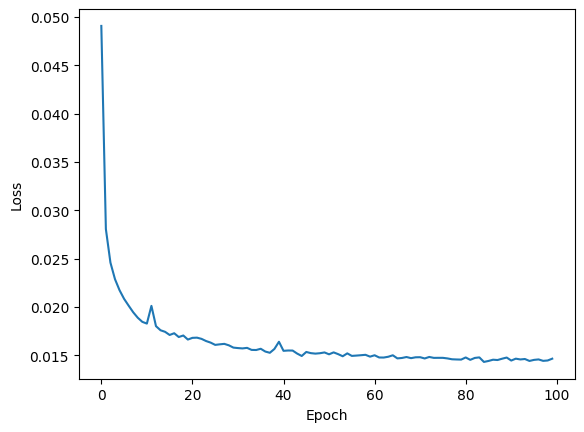

In [26]:
plt.clf()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

100%|██████████| 1000/1000 [00:06<00:00, 154.13it/s]


<Figure size 640x480 with 0 Axes>

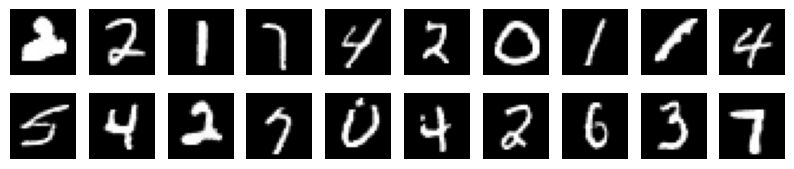

In [27]:
images = diffuser.sample(model)
show_images(images)

- 100에폭 정도 돌리면 성능이 좋아진다.(서적내 그림과 비교해보라)
- lr-scheduler같은걸 더쓰면 성능이 더 좋아질 것으로 기대된다.